In [136]:
! echo "--- Visible GPUs ---"; rocm-smi --showid;  echo ""; echo "--- Visible CPUs ---"; echo "CPUs available to this process: $(nproc)"; echo ""; echo "--- Visible Memory (RAM) ---"; free -h;

--- Visible GPUs ---
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)
/bin/bash: line 1: $'\302\240': command not found
--- Visible CPUs ---
CPUs available to this process: 256

--- Visible Memory (RAM) ---
               total        used        free      shared  buff/cache   available
Mem:           1.0Ti       633Gi       375Gi       431Mi       1.8Gi       373Gi
Swap:             0B          0B          0B


In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import sklearn as skl
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
def load_snp_csv(snp_file):
    df = pd.read_csv(snp_file)  # do NOT use index_col=0 here
    df.rename(columns={df.columns[0]: 'GID'}, inplace=True)  # First column is GID
    df = df.astype(float, errors='ignore')  # Only SNPs will be float
    return df

class MultiModalDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, image_path, geno_feature_cols, batch_size=32, shuffle=True):
        self.df = dataframe.reset_index(drop=True)
        self.image_path = image_path
        self.geno_feature_cols = geno_feature_cols
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size : (index + 1) * self.batch_size]
        
        X_img = []
        X_geno = []
        Y = []
        
        for _, row in batch_df.iterrows():
            # Load image
            img = np.load(os.path.join(self.image_path, row['Filename']))
            X_img.append(img)

            # Genomic features
            geno = row[self.geno_feature_cols].values.astype(np.float32)
            X_geno.append(geno)

            # Yield
            Y.append(row['GRYLD'])

        return [np.array(X_img), np.array(X_geno)], np.array(Y)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [4]:
geno_df = load_snp_csv("SNPs_phased_reduced.csv")

In [5]:
csv_path = "/scratch/pawsey1157/rtrivedi/dataset/Phenotypes/Images_GIDs_GRYLD.csv"
img_df = pd.read_csv(csv_path, header=None, names=['Filename', 'GID', 'GRYLD'])

In [6]:
from sklearn.model_selection import train_test_split

# Load data
#geno_df = pd.read_csv('SNPs_phased_reduced.csv')
#img_df = pd.read_csv('Images_GIDs_GRYLD.csv')

# Reset index to make GID a column again
#geno_df_reset = geno_df.reset_index()

merged_df = pd.merge(img_df, geno_df, on='GID')

# Drop any NaNs
merged_df = merged_df.dropna(subset=['GRYLD'])

# Define genomic columns
geno_feature_cols = [col for col in merged_df.columns if col not in ['GID', 'Filename', 'GRYLD']]

image_path = "/scratch/pawsey1157/rtrivedi/dataset/Phenotypes/stacked_npy/"

#train_df, val_df = train_test_split(merged_df, test_size=0.2, random_state=42)

# Extract unique GIDs
unique_gids = merged_df['GID'].unique()

# Train/test split on GIDs
train_gids, val_gids = train_test_split(unique_gids, test_size=0.2, random_state=42)

# Subset the full dataframe based on GIDs
train_df = merged_df[merged_df['GID'].isin(train_gids)].reset_index(drop=True)
val_df = merged_df[merged_df['GID'].isin(val_gids)].reset_index(drop=True)

# Create generator
train_gen = MultiModalDataGenerator(
    dataframe=train_df,
    image_path=image_path,
    geno_feature_cols=geno_feature_cols,
    batch_size=32,
    shuffle=True
)

val_gen = MultiModalDataGenerator(
    dataframe=val_df,
    image_path=image_path,
    geno_feature_cols=geno_feature_cols,
    batch_size=32,
    shuffle=False  # don't shuffle validation
)

In [7]:
# Alignment check

# Display a few rows to check alignment
sample = merged_df.sample(1).iloc[0]
print(f"GID: {sample['GID']}")
print(f"Filename: {sample['Filename']}")
print(f"Yield (GRYLD): {sample['GRYLD']:.3f}")

# Check genotype vector
geno_vector = sample[geno_feature_cols].values
print(f"Genotype shape: {geno_vector.shape}")
print(f"Non-zero SNPs: {(geno_vector != 0).sum()}, Mean: {geno_vector.mean():.4f}")

GID: GID8236435
Filename: 18-OBR-YTBW-B5I-4137-20180319_200303_IMG_0745_1.npy
Yield (GRYLD): 12.061
Genotype shape: (84322,)
Non-zero SNPs: 14106, Mean: 0.1598


In [8]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate

# Load and rename image model
image_model = load_model('CNN.h5', compile=False)
image_model._name = 'image_model'  # Rename to avoid name clash

# Load and rename genotype model
geno_model = load_model('wheat_height_predictor.h5', compile=False)
geno_model._name = 'geno_model'  # Rename to avoid name clash

# Freeze both models
for layer in image_model.layers:
    layer.trainable = False
for layer in geno_model.layers:
    layer.trainable = False

# Define new inputs
img_input = Input(shape=image_model.input_shape[1:], name='image_input')
geno_input = Input(shape=geno_model.input_shape[1:], name='geno_input')

# Pass through models
img_features = image_model(img_input)
geno_features = geno_model(geno_input)

# Combine
fusion = concatenate([img_features, geno_features], name='fusion')
x = layers.Dense(128, activation='relu', name='fusion_dense_1')(fusion)
x = layers.Dropout(0.3, name='fusion_dropout_1')(x)
#x = layers.Dense(64, activation='relu', name='fusion_dense_2')(x)
#x = layers.Dropout(0.2, name='fusion_dropout_2')(x)
output = layers.Dense(1, activation='relu', name='yield_output')(x)   # setting this to 2 makes the model produce two outputs - incompatible with downstream analysis

# Final model
fusion_model = Model(inputs=[img_input, geno_input], outputs=output)
fusion_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
history = fusion_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,         
    verbose=1
)

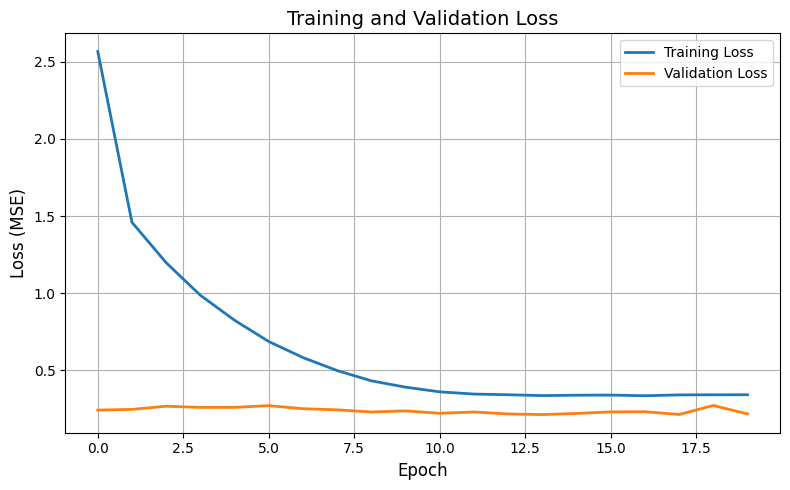

In [10]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result from model.fit()
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Disable shuffling in train_gen to make it deterministic
train_gen.shuffle = False
train_gen.on_epoch_end()  # Re-shuffle once manually if needed

# Predict on the whole generator
y_pred_train = fusion_model.predict(train_gen, verbose=1)

# Collect y_true **in sync**
y_true_train = []
for i in range(len(train_gen)):
    _, y = train_gen[i]
    y_true_train.append(y)
y_true_train = np.concatenate(y_true_train)

# Compute R²
from sklearn.metrics import r2_score
r2_train = r2_score(y_true_train, y_pred_train)
print(f"R² score (synced): {r2_train:.4f}")

4330/4330 [==============================] - 4978s 1s/step
R² score (synced): 0.8636


In [12]:
from sklearn.metrics import r2_score

y_pred_val = fusion_model.predict(val_gen)
y_true_val = np.concatenate([y for _, y in val_gen])

r2_val = r2_score(y_true_val, y_pred_val)
print(f"Validation R²: {r2_val:.4f}")

1554/1554 [==============================] - 1371s 883ms/step
Validation R²: 0.8479


In [11]:
fusion_model.save('Multimodal.h5')

/usr/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
print("Predicted range:", y_pred_train.min(), "to", y_pred_train.max())
print("True range:", y_true_train.min(), "to", y_true_train.max())

Predicted range: 0.0 to 10.304363
True range: 0.861 to 10.055


In [8]:
rmse = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
print(f"RMSE: {rmse:.4f}")

percentage_errors = ((y_true_train - y_pred_train) / (y_true_train))**2
mspe = np.mean(percentage_errors)
rmspe = np.sqrt(mspe)
print(rmspe)

NameError: name 'mean_squared_error' is not defined

In [9]:
from tensorflow.keras.models import load_model
fusion_model = load_model("Multimodal.h5")

In [21]:
print(train_df.shape)

(138534, 84325)


In [11]:
##### import shap
import numpy as np

# -----------------------
# Prepare background data
# -----------------------
# We can't take it from generators directly, so let's grab arrays from DataFrame
def get_data_from_df(df, image_path, geno_cols, max_samples=None):
    imgs = []
    genos = []
    for i, row in df.iterrows():
        if max_samples and i >= max_samples:
            break
        imgs.append(np.load(os.path.join(image_path, row['Filename'])))
        genos.append(row[geno_cols].values.astype(np.float32))
    return np.array(imgs), np.array(genos)

# Background: small random subset for speed
bg_imgs, bg_genos = get_data_from_df(train_df, image_path, geno_feature_cols, max_samples=10) #, max_samples=122566

# Test samples: also small subset for demonstration
test_imgs, test_genos = get_data_from_df(val_df, image_path, geno_feature_cols, max_samples=10) #, max_samples=49724

KeyboardInterrupt: 

In [10]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import os

def load_npy(file_path):
    return np.load(file_path)

def get_data_from_df_parallel(df, image_path, geno_cols, max_samples, n_threads=8):
    subset = df.sample(n=min(max_samples, len(df)), random_state=42)
    img_paths = [os.path.join(image_path, f) for f in subset['Filename']]

    with ThreadPoolExecutor(max_workers=n_threads) as executor:
        imgs = list(executor.map(load_npy, img_paths))

    genos = subset[geno_cols].to_numpy(dtype=np.float32)
    return np.stack(imgs), genos

bg_imgs, bg_genos = get_data_from_df_parallel(train_df, image_path, geno_feature_cols, max_samples=138534)
test_imgs, test_genos = get_data_from_df_parallel(val_df, image_path, geno_feature_cols, max_samples=33756)

In [11]:
import shap

# -----------------------
# Run SHAP
# -----------------------
explainer = shap.GradientExplainer(fusion_model, [bg_imgs, bg_genos])

# Get SHAP values for both inputs
shap_values = explainer.shap_values([test_imgs, test_genos])

# shap_values is a list: shap_values[0] → image input SHAPs, shap_values[1] → SNP input SHAPs
print("Image SHAP shape:", np.array(shap_values[0]).shape)
print("SNP SHAP shape:", np.array(shap_values[1]).shape)

/software/projects/pawsey1157/rtrivedi/setonix/pythonEnvironments/tensorflowContainer_env/machinelearning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Image SHAP shape: (33756, 145, 61, 8, 1)
SNP SHAP shape: (33756, 84322, 1)


/tmp/ipykernel_2387761/1090724627.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_geno, test_genos, feature_names=geno_feature_cols)


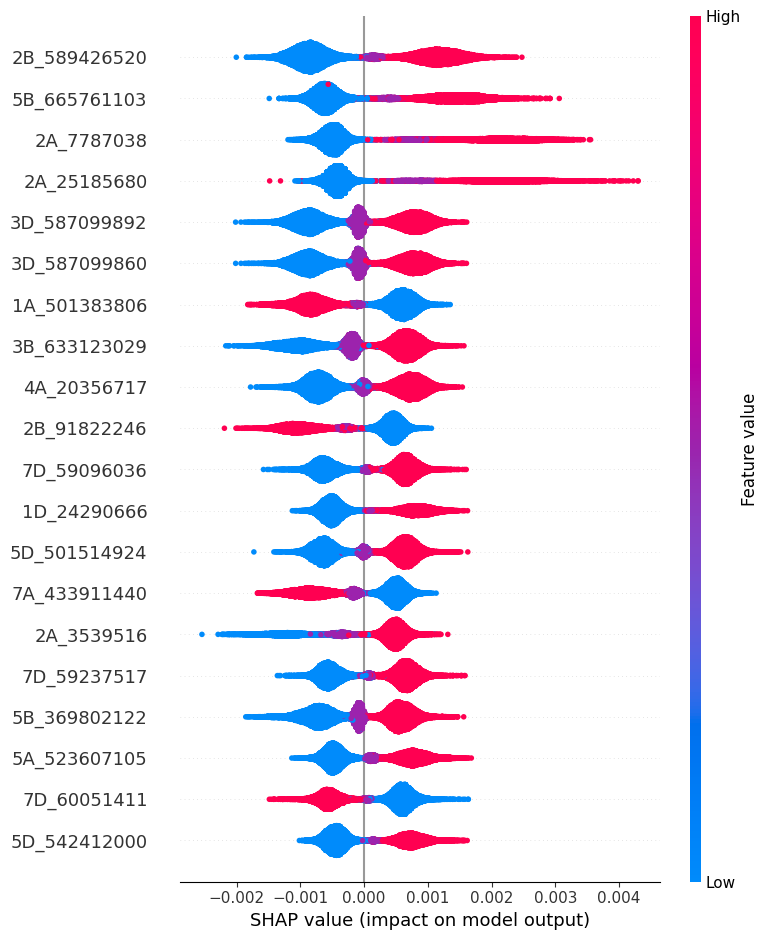

In [12]:
# -----------------------
# Plot SNP SHAP summary
# -----------------------

shap_values_geno = np.squeeze(shap_values[1])
shap.summary_plot(shap_values_geno, test_genos, feature_names=geno_feature_cols)

In [19]:
selected_filenames=['18-OBR-YTBW-B5I-29860-20180321_210741_IMG_0978_1.npy', '18-OBR-YTBW-B5I-31554-20180321_204548_IMG_0043_1.npy', '18-OBR-YTBW-B5I-30755-20180321_202851_IMG_0766_1.npy', '18-OBR-YTBW-B5I-27503-20180321_205056_IMG_0285_1.npy', '18-OBR-YTBW-B5I-29957-20180321_210238_IMG_0736_1.npy', '18-OBR-YTBW-B5I-30205-20180321_205823_IMG_0647_1.npy', '18-OBR-YTBW-B5I-5522-20180319_195944_IMG_0583_1.npy', '18-OBR-YTBW-B5I-8235-20180315_214830_IMG_1018_1.npy', '18-OBR-YTBW-B5I-8235-20180315_220230_IMG_1516_1.npy', '18-OBR-YTBW-B5I-8235-20180315_214828_IMG_1017_1.npy']
# Get matching rows from merged_df (multimodal DF)
selected_multi_df = img_df[img_df['Filename'].isin(selected_filenames)].copy()
# preserve order
selected_multi_df['__order'] = selected_multi_df['Filename'].apply(lambda f: selected_filenames.index(f))
selected_multi_df = selected_multi_df.sort_values('__order').drop(columns='__order').reset_index(drop=True)

/tmp/ipykernel_1055372/2862835376.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_geno, test_genos, feature_names=geno_feature_cols)


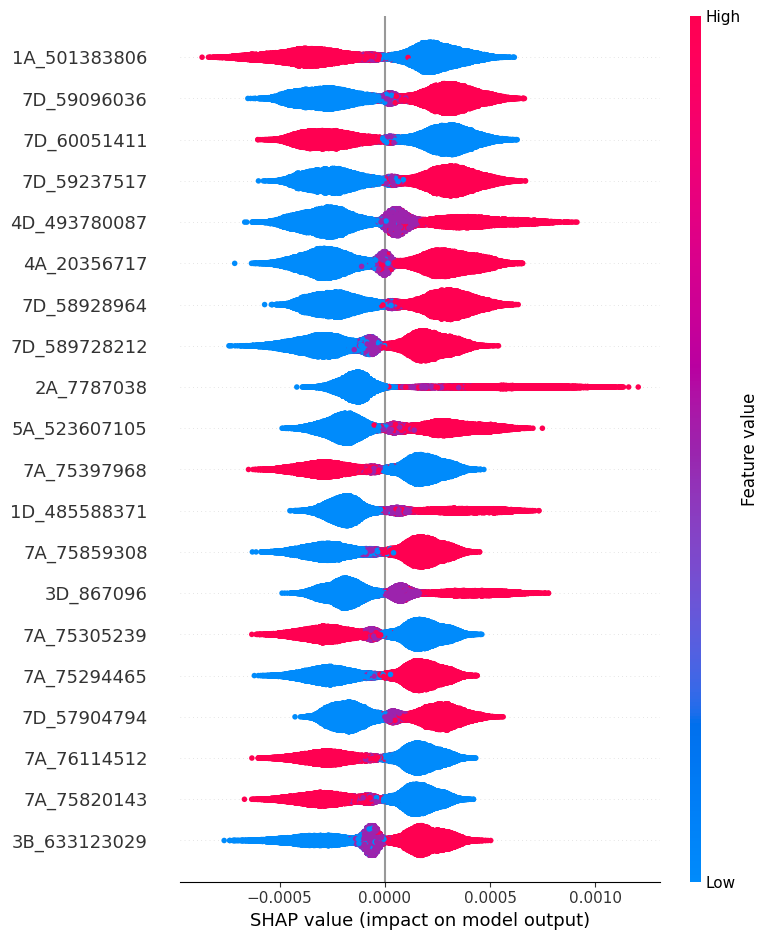

In [23]:
# -----------------------
# Plot SNP SHAP summary
# -----------------------

shap_values_geno = np.squeeze(shap_values[1])
shap.summary_plot(shap_values_geno, test_genos, feature_names=geno_feature_cols)


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example: shap_values_snp is your array from SHAP for SNP-only model
# shape = (n_samples, n_snps)
# snp_names = list or array of SNP column names, e.g. ["2A_1145442", "7D_99123", ...]

mean_abs_shap = np.mean(np.abs(shap_values_geno), axis=0)

snp_df = pd.DataFrame({
    "SNP": geno_feature_cols,
    "mean_abs_shap": mean_abs_shap
})

In [16]:
snp_df["Chromosome"] = snp_df["SNP"].str.extract(r"^([0-9A-Z]+)_")

In [17]:
chrom_shap = (
    snp_df.groupby("Chromosome")["mean_abs_shap"]
    .mean()
    .sort_values(ascending=False)
)

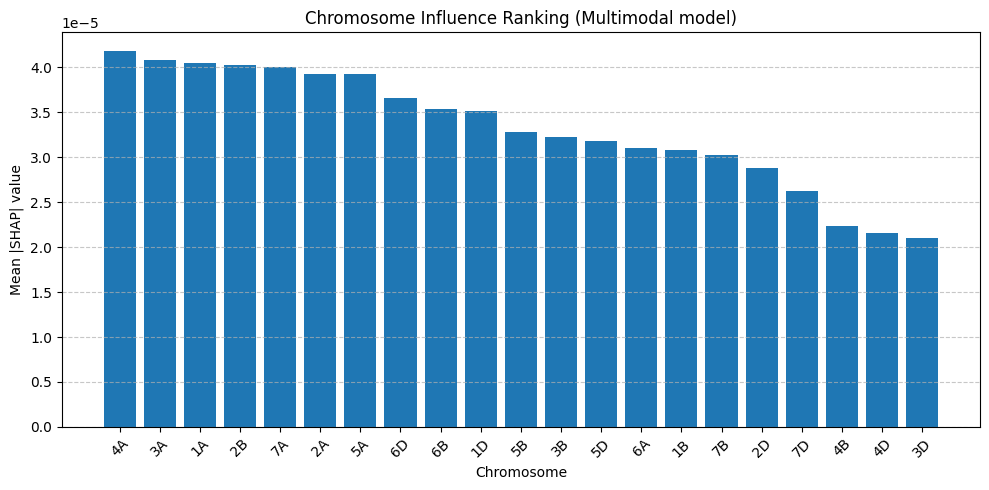

In [135]:
plt.figure(figsize=(10, 5))
plt.bar(chrom_shap.index, chrom_shap.values)
plt.xlabel("Chromosome")
plt.ylabel("Mean |SHAP| value")
plt.title("Chromosome Influence Ranking (Multimodal model)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [36]:
# Collect full arrays from val_gen
all_imgs = []
all_genos = []
y_true = []

for (x_batch, y_batch) in val_gen:
    all_imgs.append(x_batch[0])   # images
    all_genos.append(x_batch[1])  # SNPs
    y_true.append(y_batch)

# Concatenate into single arrays
all_imgs = np.concatenate(all_imgs, axis=0)
all_genos = np.concatenate(all_genos, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Now predict safely
y_pred = fusion_model.predict([all_imgs, all_genos], verbose=0).flatten()

## Compute errors
#errors = np.abs(y_true - y_pred)
#
## Sort indices by error
#sorted_idx = np.argsort(errors)
#best_idx = sorted_idx[:5]   # 5 smallest errors
#worst_idx = sorted_idx[-5:] # 5 largest errors

In [21]:
print(selected_multi_df)

                                            Filename         GID      GRYLD
0  18-OBR-YTBW-B5I-29860-20180321_210741_IMG_0978...  GID8248515  11.792388
1  18-OBR-YTBW-B5I-31554-20180321_204548_IMG_0043...  GID8249463  13.863322
2  18-OBR-YTBW-B5I-30755-20180321_202851_IMG_0766...  GID8248992  11.813149
3  18-OBR-YTBW-B5I-27503-20180321_205056_IMG_0285...  GID8247618  12.958478
4  18-OBR-YTBW-B5I-29957-20180321_210238_IMG_0736...  GID8248579  12.750865
5  18-OBR-YTBW-B5I-30205-20180321_205823_IMG_0647...  GID8248706  16.735294
6  18-OBR-YTBW-B5I-5522-20180319_195944_IMG_0583_...  GID8236979   9.761246
7  18-OBR-YTBW-B5I-8235-20180315_214830_IMG_1018_...  GID8238190   1.489619
8  18-OBR-YTBW-B5I-8235-20180315_220230_IMG_1516_...  GID8238190   1.489619
9  18-OBR-YTBW-B5I-8235-20180315_214828_IMG_1017_...  GID8238190   1.489619


Total selected images: 10
First few filenames: ['18-OBR-YTBW-B5I-29860-20180321_210741_IMG_0978_1.npy', '18-OBR-YTBW-B5I-31554-20180321_204548_IMG_0043_1.npy', '18-OBR-YTBW-B5I-30755-20180321_202851_IMG_0766_1.npy', '18-OBR-YTBW-B5I-27503-20180321_205056_IMG_0285_1.npy', '18-OBR-YTBW-B5I-29957-20180321_210238_IMG_0736_1.npy', '18-OBR-YTBW-B5I-30205-20180321_205823_IMG_0647_1.npy', '18-OBR-YTBW-B5I-5522-20180319_195944_IMG_0583_1.npy', '18-OBR-YTBW-B5I-8235-20180315_214830_IMG_1018_1.npy', '18-OBR-YTBW-B5I-8235-20180315_220230_IMG_1516_1.npy', '18-OBR-YTBW-B5I-8235-20180315_214828_IMG_1017_1.npy']


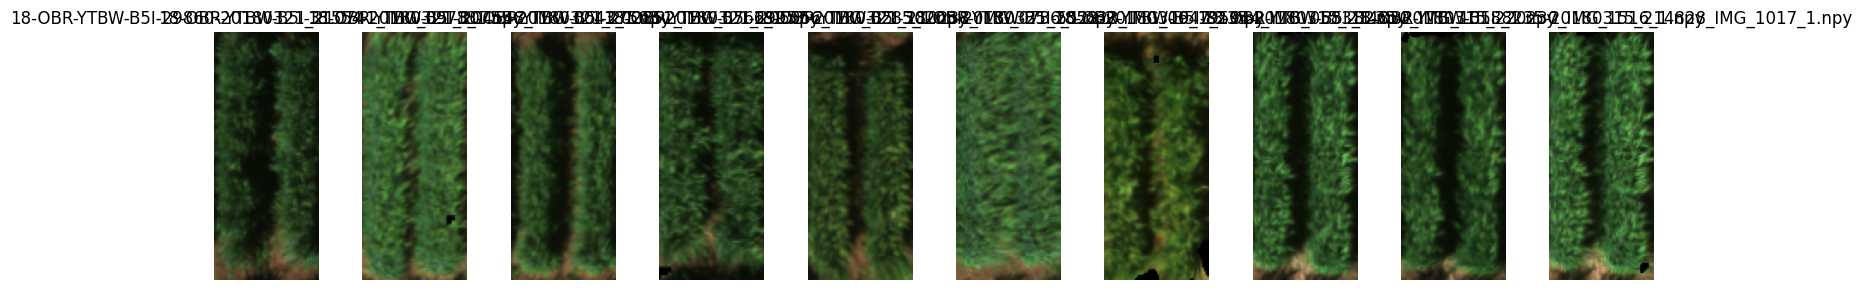

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Make sure the selected_filenames are valid
print(f"Total selected images: {len(selected_filenames)}")
print("First few filenames:", selected_filenames[:10])

# Plot the first few images
n_show = min(10, len(selected_filenames))
plt.figure(figsize=(15, 3))

for i, fname in enumerate(selected_filenames[:n_show]):
    img = np.load(os.path.join(image_path, fname))  # load .npy RGB array
    plt.subplot(1, n_show, i + 1)
    img_rgb=img[:, :, :3]
    plt.imshow(img_rgb.astype(np.float32))  # ensure numeric type
    plt.axis('off')
    plt.title(fname.split('/')[-1])  # show filename only

plt.tight_layout()
plt.show()

In [32]:
# Select data and SHAP values for those filenames
shap_values_img=shap_values[0]

X_selected = test_imgs[selected_idx]
y_true_selected = y_true_val[selected_idx]
y_pred_selected = y_pred_val[selected_idx]
shap_selected = shap_values_img[selected_idx]

shap_values = explainer.shap_values(X_selected)
shap_vals = shap_values[0] if isinstance(shap_values, list) else shap_values
shap_sum = np.sum(np.abs(shap_vals), axis=-1)  # (n_samples, H, W)

import matplotlib.pyplot as plt

def plot_shap_images(X, shap_sum, y_true, y_pred, indices, title):
    # Make figure 3× larger (was 12x10 → now 36x30)
    plt.figure(figsize=(36, 30))
    
    for i, idx in enumerate(indices):
        img = X[idx, :, :, :3]  # use first 3 bands as RGB proxy
        shap_img = shap_sum[idx]

        # --- Original Image ---
        plt.subplot(5, 2, 2*i + 1)
        plt.imshow(img / np.max(img))  # normalize for display
        plt.title(f"Original (Y={y_true[idx]:.2f}, Pred={y_pred[idx]:.2f})",
                  fontsize=24, pad=20)
        plt.axis("off")

        # --- SHAP Heatmap ---
        plt.subplot(5, 2, 2*i + 2)
        im = plt.imshow(np.sum(np.abs(shap_img), axis=-1), cmap='BuPu')
        plt.title("Summed |SHAP| across 8 bands", fontsize=24, pad=20)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.axis("off")

    plt.suptitle(title, fontsize=36, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()



AssertionError: Expected a list of model inputs!

Generating predictions...
1055/1055 [==============================] - 915s 867ms/step

--- Model Performance ---
Train R²: 0.8483
Val R²: 0.8440
Train RMSE: 0.4951
Val RMSE: 0.4673
Train RMSPE (%): 6.0510
Val RMSPE (%): 3.7449


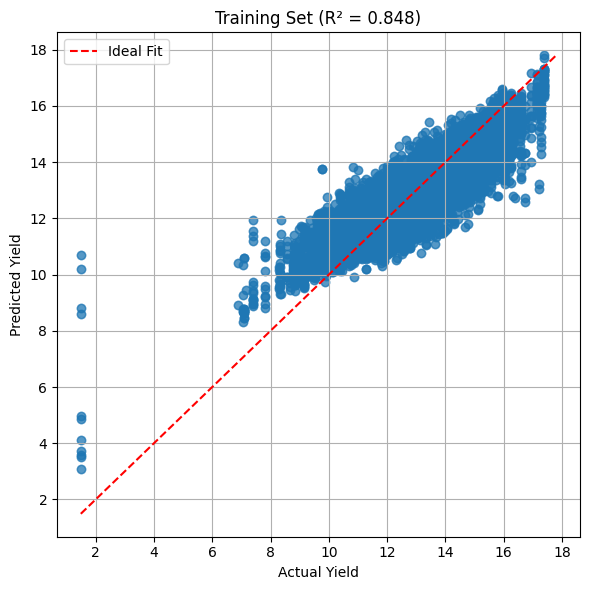

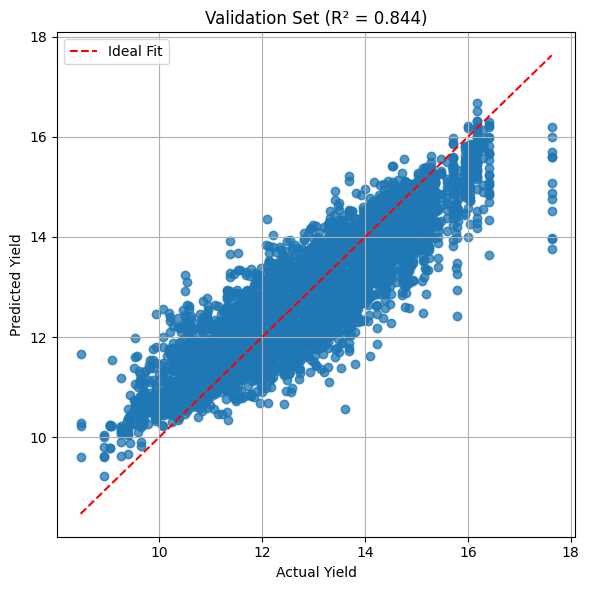

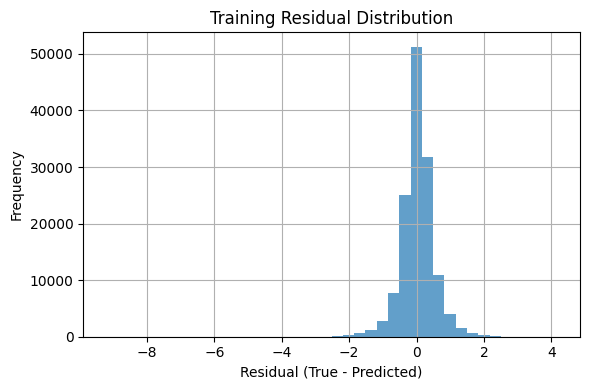

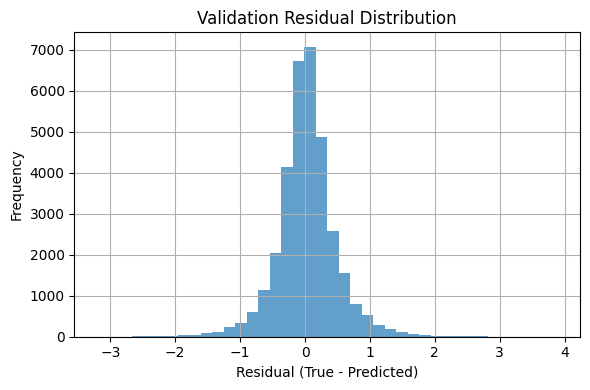

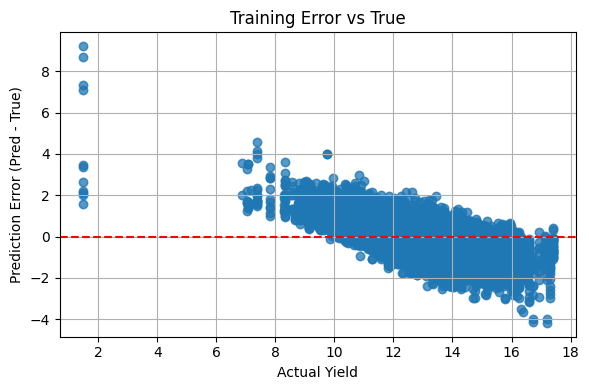

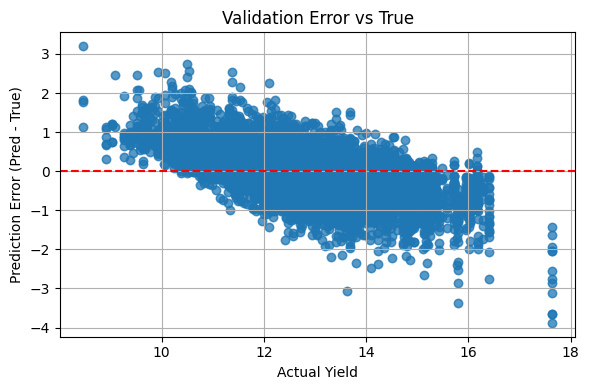

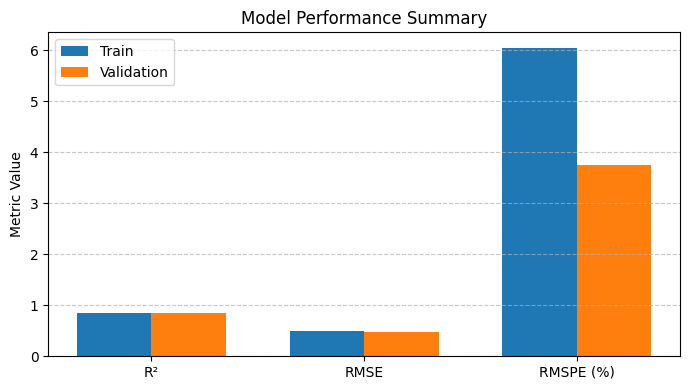

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# --- 1. Define Metrics ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmspe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.sqrt(np.mean(((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2)) * 100

# --- 2. Get predictions ---
print("Generating predictions...")
y_true_train = np.concatenate([y for _, y in train_gen])
y_pred_train = fusion_model.predict(train_gen).flatten()

y_true_val = np.concatenate([y for _, y in val_gen])
y_pred_val = fusion_model.predict(val_gen).flatten()

# --- 3. Compute Metrics ---
metrics = {
    'Train R²': r2_score(y_true_train, y_pred_train),
    'Val R²': r2_score(y_true_val, y_pred_val),
    'Train RMSE': rmse(y_true_train, y_pred_train),
    'Val RMSE': rmse(y_true_val, y_pred_val),
    'Train RMSPE (%)': rmspe(y_true_train, y_pred_train),
    'Val RMSPE (%)': rmspe(y_true_val, y_pred_val),
}

print("\n--- Model Performance ---")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# --- 4. Plot: Predicted vs Actual ---
def plot_pred_vs_actual(y_true, y_pred, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit")
    plt.xlabel("Actual Yield")
    plt.ylabel("Predicted Yield")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pred_vs_actual(y_true_train, y_pred_train, f"Training Set (R² = {metrics['Train R²']:.3f})")
plot_pred_vs_actual(y_true_val, y_pred_val, f"Validation Set (R² = {metrics['Val R²']:.3f})")

# --- 5. Plot: Residuals ---
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    plt.hist(residuals, bins=40, alpha=0.7)
    plt.title(title)
    plt.xlabel("Residual (True - Predicted)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_residuals(y_true_train, y_pred_train, "Training Residual Distribution")
plot_residuals(y_true_val, y_pred_val, "Validation Residual Distribution")

# --- 6. Error vs True Plot ---
def plot_error_vs_true(y_true, y_pred, title):
    error = y_pred - y_true
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, error, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(title)
    plt.xlabel("Actual Yield")
    plt.ylabel("Prediction Error (Pred - True)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_error_vs_true(y_true_train, y_pred_train, "Training Error vs True")
plot_error_vs_true(y_true_val, y_pred_val, "Validation Error vs True")

# --- 7. Optional: Combined Summary Plot ---
labels = ['R²', 'RMSE', 'RMSPE (%)']
train_vals = [metrics['Train R²'], metrics['Train RMSE'], metrics['Train RMSPE (%)']]
val_vals = [metrics['Val R²'], metrics['Val RMSE'], metrics['Val RMSPE (%)']]

plt.figure(figsize=(7, 4))
x = np.arange(len(labels))
width = 0.35
plt.bar(x - width/2, train_vals, width, label='Train')
plt.bar(x + width/2, val_vals, width, label='Validation')
plt.xticks(x, labels)
plt.ylabel("Metric Value")
plt.title("Model Performance Summary")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipykernel_720700/1824697368.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_errors, val_errors],


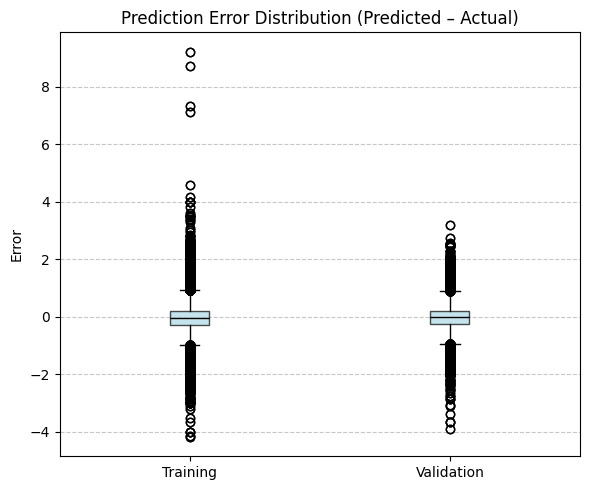

/tmp/ipykernel_720700/1824697368.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(residuals_by_bin,


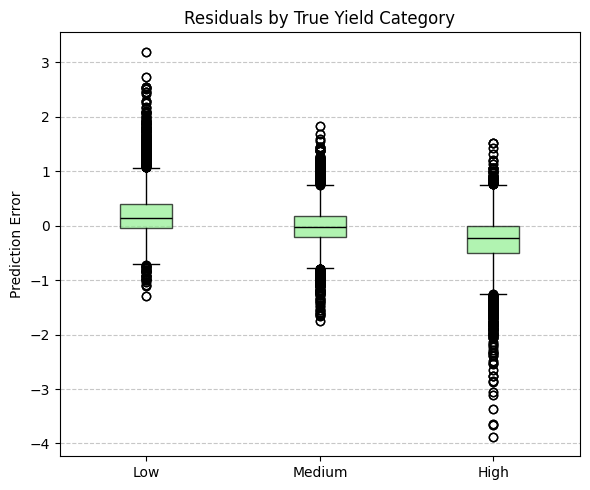

In [21]:
# --- 6. Error distributions ---
train_errors = y_pred_train - y_true_train
val_errors = y_pred_val - y_true_val

plt.figure(figsize=(6, 5))
plt.boxplot([train_errors, val_errors],
            labels=["Training", "Validation"],
            patch_artist=True,
            medianprops=dict(color='black'),
            boxprops=dict(facecolor='lightblue', alpha=0.7))
plt.title("Prediction Error Distribution (Predicted – Actual)")
plt.ylabel("Error")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 7. Yield binning for residual analysis ---
percentiles = np.percentile(y_true_val, [33.3, 66.6])
bins = [y_true_val.min() - 1, percentiles[0], percentiles[1], y_true_val.max() + 1]
labels = ["Low", "Medium", "High"]

y_true_bins = np.digitize(y_true_val, bins) - 1
y_pred_bins = np.digitize(y_pred_val, bins) - 1

# --- 8. Boxplot of residuals by yield bin ---
residuals_by_bin = [val_errors[y_true_bins == i] for i in range(3)]
plt.figure(figsize=(6,5))
plt.boxplot(residuals_by_bin,
            labels=labels,
            patch_artist=True,
            medianprops=dict(color='black'),
            boxprops=dict(facecolor='lightgreen', alpha=0.7))
plt.title("Residuals by True Yield Category")
plt.ylabel("Prediction Error")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

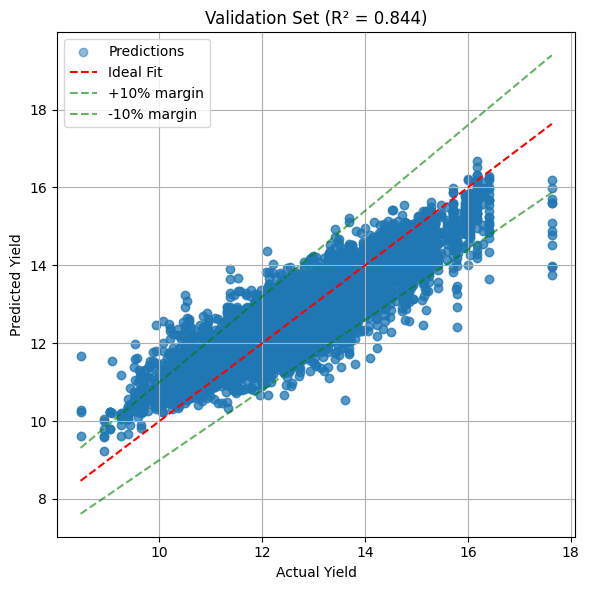

In [20]:
def plot_pred_vs_actual_with_band(y_true, y_pred, title, band=0.1):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5, label="Predictions")
    min_val, max_val = np.min(y_true), np.max(y_true)
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit")

    # ±band lines (e.g., ±10%)
    plt.plot([min_val, max_val], [min_val*(1+band), max_val*(1+band)], 'g--', alpha=0.6, label=f"+{int(band*100)}% margin")
    plt.plot([min_val, max_val], [min_val*(1-band), max_val*(1-band)], 'g--', alpha=0.6, label=f"-{int(band*100)}% margin")

    plt.xlabel("Actual Yield")
    plt.ylabel("Predicted Yield")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pred_vs_actual_with_band(
    y_true_val, y_pred_val,
    f"Validation Set (R² = {metrics['Val R²']:.3f})"
)

In [14]:
plot_pred_vs_actual_with_band(
    y_true_train, y_pred_train,
    f"Training Set (R² = {metrics_train['R²'][0]:.3f})"
)

NameError: name 'plot_pred_vs_actual_with_band' is not defined


Yield Bin Summary (Validation Set):
Category   Range (t/ha)         Proportion (%) 
Low        7.47 – 12.10         33.1%
Medium     12.10 – 13.07         33.4%
High       13.07 – 18.63         33.5%


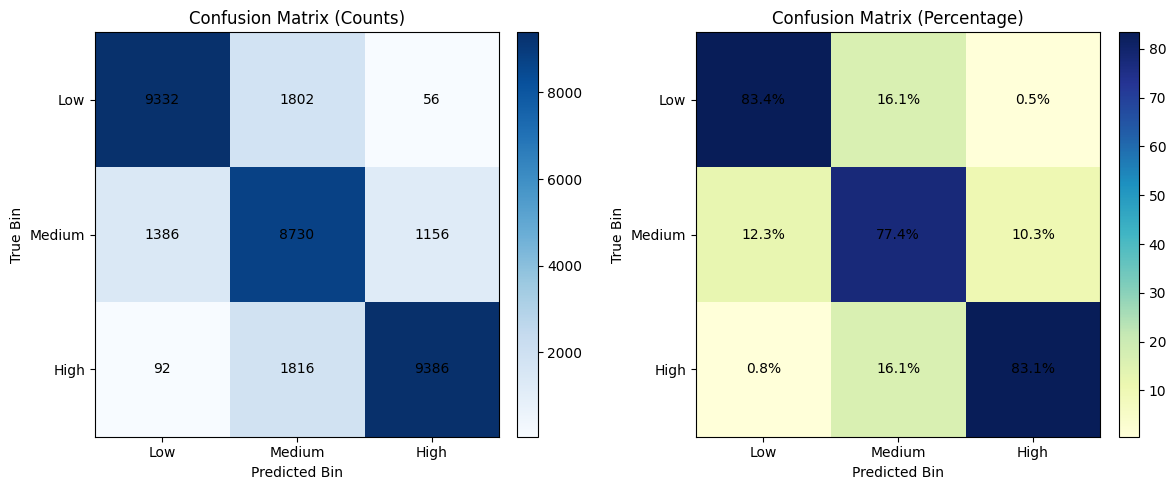


Normalized Confusion Matrix (%):
               Low       Medium      High   
Low              83.4       16.1        0.5
Medium           12.3       77.4       10.3
High              0.8       16.1       83.1


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- 1. Print bin range summary ---
bin_labels = ["Low", "Medium", "High"]

bin_ranges = [(bins[i], bins[i + 1]) for i in range(3)]
proportions = [np.sum(y_true_bins == i) / len(y_true_bins) * 100 for i in range(3)]

print("\nYield Bin Summary (Validation Set):")
print(f"{'Category':<10} {'Range (t/ha)':<20} {'Proportion (%)':<15}")
for lbl, (low, high), prop in zip(bin_labels, bin_ranges, proportions):
    print(f"{lbl:<10} {low:.2f} – {high:.2f} {prop:>12.1f}%")

# --- 2. Compute confusion matrices ---
cm = confusion_matrix(y_true_bins, y_pred_bins, labels=[0, 1, 2])
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100  # Normalize row-wise

# --- 3. Plot confusion matrices (counts and % side by side) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Absolute counts
im1 = axes[0].imshow(cm, cmap='Blues')
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted Bin")
axes[0].set_ylabel("True Bin")
axes[0].set_xticks(np.arange(len(bin_labels)))
axes[0].set_yticks(np.arange(len(bin_labels)))
axes[0].set_xticklabels(bin_labels)
axes[0].set_yticklabels(bin_labels)

# Annotate
for i in range(len(bin_labels)):
    for j in range(len(bin_labels)):
        axes[0].text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Normalized (%)
im2 = axes[1].imshow(cm_norm, cmap='YlGnBu')
axes[1].set_title("Confusion Matrix (Percentage)")
axes[1].set_xlabel("Predicted Bin")
axes[1].set_ylabel("True Bin")
axes[1].set_xticks(np.arange(len(bin_labels)))
axes[1].set_yticks(np.arange(len(bin_labels)))
axes[1].set_xticklabels(bin_labels)
axes[1].set_yticklabels(bin_labels)

# Annotate with percentage values
for i in range(len(bin_labels)):
    for j in range(len(bin_labels)):
        axes[1].text(j, i, f"{cm_norm[i, j]:.1f}%", ha="center", va="center", color="black")

plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# --- 4. Optional: Print numeric confusion matrix (percentages) ---
print("\nNormalized Confusion Matrix (%):")
print(" " * 12 + " ".join(f"{lbl:^10}" for lbl in bin_labels))
for i, lbl in enumerate(bin_labels):
    row = " ".join(f"{cm_norm[i, j]:10.1f}" for j in range(len(bin_labels)))
    print(f"{lbl:<10} {row}")

In [113]:
X_img_selected = test_imgs[selected_idx]
X_snp_selected = test_genos[selected_idx]
y_true_selected = y_true_val[selected_idx]
y_pred_selected = y_pred_val[selected_idx]

# ------------------------------------------------------
# Step 3: Compute SHAP values for the selected samples
# ------------------------------------------------------
shap_values_selected = explainer.shap_values([selected_img_df, selected_snp_df])

# If explainer returns a list (for multimodal), pick the image component
shap_vals_img = shap_values_selected[0] if isinstance(shap_values_selected, list) else shap_values_selected

# Sum absolute SHAP values across bands (|SHAP| per pixel)
shap_sum = np.sum(np.abs(shap_vals_img), axis=-1)

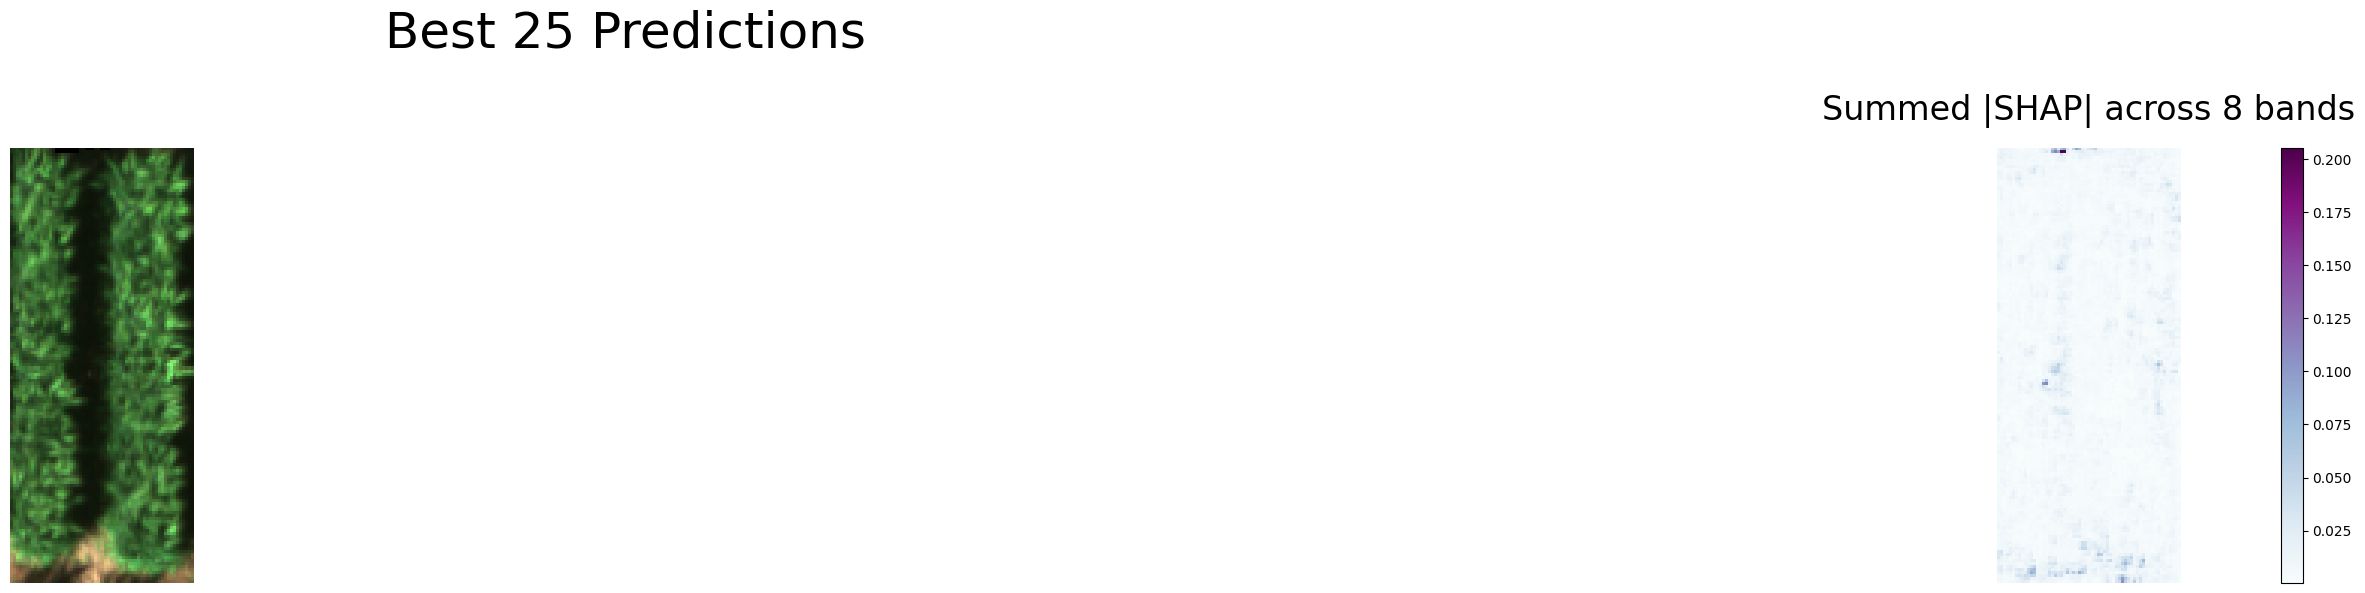

In [134]:
import matplotlib.pyplot as plt
import math

def plot_shap_images(X, shap_sum, indices, title):
    n_samples = len(indices)
    n_rows = math.ceil(n_samples)  # 1 row per sample (2 subplots each)
    plt.figure(figsize=(36, 6*n_samples))  # scale height by #samples
    
    for i, idx in enumerate(indices):
        img = X[idx, :, :, :3]  # first 3 bands as RGB proxy
        shap_img = shap_sum[idx]

        # Original Image
        plt.subplot(n_samples, 2, 2*i + 1)
        plt.imshow(img / np.max(img))
        #plt.title(f"Original (Y={y_true[idx]:.2f}, Pred={y_pred[idx]:.2f})", fontsize=24, pad=20)
        plt.axis("off")

        # SHAP heatmap
        plt.subplot(n_samples, 2, 2*i + 2)
        im = plt.imshow(np.sum(np.abs(shap_img), axis=-1), cmap='BuPu')
        plt.title("Summed |SHAP| across 8 bands", fontsize=24, pad=20)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.axis("off")

    plt.suptitle(title, fontsize=36, y=0.98)
    plt.tight_layout(rect=[0,0,1,0.97])
    plt.show()

# --- Plot best and worst ---
plot_shap_images(selected_img_df, shap_sum, range(20,21), "Best 25 Predictions")

In [75]:
selected_filenames=['18-OBR-YTBW-B5I-29860-20180321_210741_IMG_0978_1.npy', '18-OBR-YTBW-B5I-31554-20180321_204548_IMG_0043_1.npy', '18-OBR-YTBW-B5I-30755-20180321_202851_IMG_0766_1.npy', '18-OBR-YTBW-B5I-27503-20180321_205056_IMG_0285_1.npy', '18-OBR-YTBW-B5I-29957-20180321_210238_IMG_0736_1.npy', '18-OBR-YTBW-B5I-30205-20180321_205823_IMG_0647_1.npy', '18-OBR-YTBW-B5I-5522-20180319_195944_IMG_0583_1.npy', '18-OBR-YTBW-B5I-8235-20180315_214830_IMG_1018_1.npy', '18-OBR-YTBW-B5I-8235-20180315_220230_IMG_1516_1.npy', '18-OBR-YTBW-B5I-8235-20180315_214828_IMG_1017_1.npy']

# Filter merged_df to only the selected filenames
selected_df = merged_df[merged_df['Filename'].isin(selected_filenames)]

# Check
print(f"Number of selected rows: {len(selected_df)}")
print(selected_df.head())

Number of selected rows: 22
                                                Filename         GID  \
42410  18-OBR-YTBW-B5I-27503-20180321_205056_IMG_0285...  GID8247618   
42411  18-OBR-YTBW-B5I-27503-20180321_205056_IMG_0285...  GID8247618   
86408  18-OBR-YTBW-B5I-29860-20180321_210741_IMG_0978...  GID8248515   
86409  18-OBR-YTBW-B5I-29860-20180321_210741_IMG_0978...  GID8248515   
88138  18-OBR-YTBW-B5I-29957-20180321_210238_IMG_0736...  GID8248579   

           GRYLD  1A_1145442  1A_1158042  1A_1158055  1A_1197644  1A_1229010  \
42410  12.958478         0.0         0.0         0.0         0.0         0.0   
42411  12.958478         0.0         0.0         0.0         0.0         0.0   
86408  11.792388         0.5         0.5         0.0         0.0         0.5   
86409  11.792388         0.5         0.5         0.0         0.0         0.5   
88138  12.750865         0.0         1.0         1.0         0.0         0.0   

       1A_1229616  1A_1229618  ...  7D_638146836  7D_63820

In [84]:
print(X_img_selected.shape)

(50, 145, 61, 8)


In [85]:
print(img_df.shape)

(85855, 3)


In [110]:
print(type(test_genos))

<class 'numpy.ndarray'>


In [111]:
selected_snp_df = selected_df.drop(selected_df.columns[[0, 1, 2]], axis=1)
selected_snp_df = selected_snp_df.to_numpy(dtype=np.float32)

In [102]:
import os
image_path = "/scratch/pawsey1157/rtrivedi/dataset/Phenotypes/stacked_npy/"
selected_img_df = np.stack([np.load(os.path.join(image_path, fname)) for fname in selected_df['Filename']])

In [112]:
print(type(selected_snp_df))
print(type(selected_img_df))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [115]:
selected_df['Filename']

42410     18-OBR-YTBW-B5I-27503-20180321_205056_IMG_0285...
42411     18-OBR-YTBW-B5I-27503-20180321_205056_IMG_0285...
86408     18-OBR-YTBW-B5I-29860-20180321_210741_IMG_0978...
86409     18-OBR-YTBW-B5I-29860-20180321_210741_IMG_0978...
88138     18-OBR-YTBW-B5I-29957-20180321_210238_IMG_0736...
88139     18-OBR-YTBW-B5I-29957-20180321_210238_IMG_0736...
92602     18-OBR-YTBW-B5I-30205-20180321_205823_IMG_0647...
92603     18-OBR-YTBW-B5I-30205-20180321_205823_IMG_0647...
103456    18-OBR-YTBW-B5I-30755-20180321_202851_IMG_0766...
103457    18-OBR-YTBW-B5I-30755-20180321_202851_IMG_0766...
115822    18-OBR-YTBW-B5I-31554-20180321_204548_IMG_0043...
115823    18-OBR-YTBW-B5I-31554-20180321_204548_IMG_0043...
140102    18-OBR-YTBW-B5I-5522-20180319_195944_IMG_0583_...
140103    18-OBR-YTBW-B5I-5522-20180319_195944_IMG_0583_...
140104    18-OBR-YTBW-B5I-5522-20180319_195944_IMG_0583_...
140105    18-OBR-YTBW-B5I-5522-20180319_195944_IMG_0583_...
157578    18-OBR-YTBW-B5I-8235-20180315_